In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-11-15-22-08-29-780194


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "BreakoutNoFrameskip-v4"
env_type = "atari"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0


In [4]:
checkpoint_min = 100
checkpoint_max = 3600
checkpoint_step = 100
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00200', '00300', '00400', '00500', '00600', '00700', '00800', '00900', '01000', '01100', '01200', '01300', '01400', '01500', '01600', '01700', '01800', '01900', '02000', '02100', '02200', '02300', '02400', '02500', '02600', '02700', '02800', '02900', '03000', '03100', '03200', '03300', '03400', '03500', '03600']


In [5]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/breakout/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 1
    done = False
    traj = []
    r = 0
    for i in range(episode_count):
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
                
    demonstrations.append(traj)
    learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 389, return: [6.]
checkpoint: 00200, steps: 421, return: [7.]
checkpoint: 00300, steps: 755, return: [23.]
checkpoint: 00400, steps: 961, return: [30.]
checkpoint: 00500, steps: 905, return: [35.]
checkpoint: 00600, steps: 1158, return: [36.]
checkpoint: 00700, steps: 1619, return: [91.]
checkpoint: 00800, steps: 1264, return: [62.]
checkpoint: 00900, steps: 850, return: [41.]
checkpoint: 01000, steps: 1130, return: [54.]
checkpoint: 01100, steps: 1388, return: [67.]
checkpoint: 01200, steps: 1841, return: [160.]
checkpoint: 01300, steps: 1218, return: [63.]
checkpoint: 01400, steps: 1372, return: [102.]
checkpoint: 01500, steps: 1495, return: [145.]
checkpoint: 01600, steps: 1528, return: [242.]
checkpoint: 01700, steps: 2203, return: [264.]
checkpoint: 01800, steps: 1895, return: [301.]
checkpoint: 01900, steps: 1413, return: [75.]
checkpoint: 02000, steps: 2156, return: [338.]
checkpoint: 02100, steps: 1763, return: [171.]
checkpoint: 02200, steps: 2228, re

Let's plot the returns to see if they are roughly monotonically increasing.

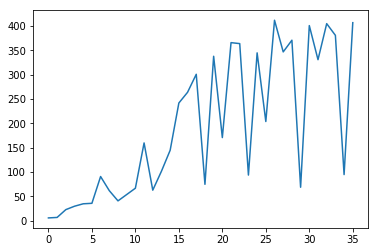

In [7]:
plt.plot(learning_returns)
plt.show()

Split the data into train and validation sets

Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        self.fc1 = nn.Linear(2592, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            #x = x.view(-1,4,84,84)
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 2592)
            x = F.leaky_relu(self.fc1(x))
            r = torch.tanh(self.fc2(x))
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [16]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j such that i > j
        j = np.random.randint(len(trajectories)-1) #make sure there is at least one later trajectory
        i = np.random.randint(j+1,len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        labels = np.array([[0]])
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 20 == 19:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 100)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

In [26]:
reward = Net()
reward.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward.parameters(), lr = 0.00001)
learn_reward(reward, optimizer, demonstrations, 200)

RuntimeError: CUDA error: out of memory

Print out learned return for all demos. should be roughly increasing

In [100]:
with torch.no_grad():
    print(torch.cat([reward.cum_return(torch.from_numpy(np.array(traj)).float().to(device)) for traj in demonstrations]))

tensor([[ 6.3470],
        [10.4219],
        [16.0051],
        [21.5090],
        [25.9470]], device='cuda:0')


Look at predicted reward over last demo. It's all +1 since demos are monotonically increasing. Maybe need to truncate demos to fixed length?

0
1
2
3
4


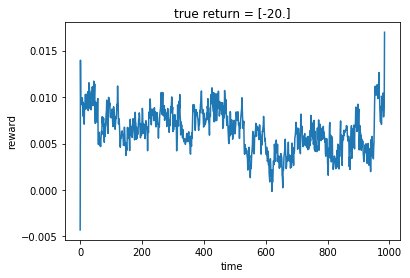

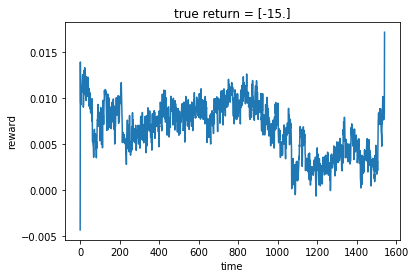

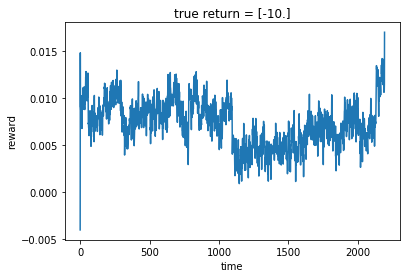

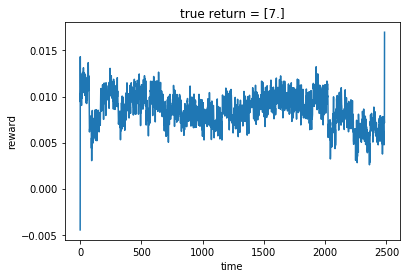

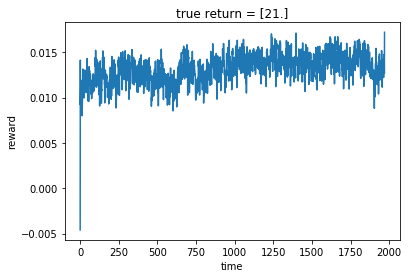

In [101]:

#for last demo

cnt = 0
with torch.no_grad():
    for d in demonstrations:
        rewards = []
        print(cnt)
        for s in d:
            r = reward.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(learning_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()


Try to fix at length of first demo... Doesn't seem to really work. Maybe use smaller neural net? there's gotta be something different in the different demos, right?

In [24]:
H = len(demonstrations[0])
demos_fh = [d[len(d)-H:] for d in demonstrations]
reward_fh = Net()
reward_fh.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward_fh.parameters(), lr = 0.00001)
learn_reward(reward_fh, optimizer, demos_fh, 1000)

19 0.2506608581542969
39 0.12473030090332031
59 0.09319393157958984
79 0.1626300048828125
99 0.1464107894897461
119 0.07840713500976562
139 0.1250637435913086
159 0.11913192749023438
179 0.10524288177490235
199 0.08392753601074218
219 0.09512245178222656
239 0.12071662902832031
259 0.08519638061523438
279 0.09207790374755859
299 0.08953807830810546
319 0.09271728515625
339 0.08675277709960938
359 0.07228282928466796
379 0.0822222900390625
399 0.0676101303100586
419 0.07618122100830078
439 0.02960521697998047
459 0.07737804412841796
479 0.060764427185058596
499 0.06695850372314453
519 0.06190074920654297
539 0.05099220275878906
559 0.07536891937255859
579 0.05866477966308594
599 0.09487258911132812
619 0.06604881286621093
639 0.04921585083007812
659 0.056552276611328126
679 0.04496524810791016
699 0.043631553649902344
719 0.047226905822753906
739 0.051899566650390624
759 0.03682262420654297
779 0.026293601989746094
799 0.061120185852050785
819 0.06954967498779296
839 0.05183364868164062

In [25]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in demos_fh]
for i, p in enumerate(pred_returns):
    print(i,p,learning_returns[i])

0 33.65531539916992 [6.]
1 33.46473693847656 [7.]
2 33.35065460205078 [23.]
3 34.397361755371094 [30.]
4 37.01109313964844 [35.]
5 36.87866973876953 [36.]
6 37.68101501464844 [91.]
7 37.27519989013672 [62.]
8 34.90338134765625 [41.]
9 37.170166015625 [54.]
10 37.594451904296875 [67.]
11 37.62485885620117 [160.]
12 37.94807815551758 [63.]
13 38.407291412353516 [102.]
14 37.49245071411133 [145.]
15 39.593929290771484 [242.]
16 38.326255798339844 [264.]
17 39.99466323852539 [301.]
18 39.09551239013672 [75.]
19 38.480712890625 [338.]
20 38.79682540893555 [171.]
21 40.03117370605469 [366.]
22 39.619754791259766 [364.]
23 40.15789794921875 [94.]
24 40.501808166503906 [345.]
25 40.10926055908203 [204.]
26 40.97897720336914 [412.]
27 40.95470428466797 [347.]
28 41.177425384521484 [371.]
29 41.214515686035156 [69.]
30 42.93531036376953 [401.]
31 41.939292907714844 [331.]
32 42.32255172729492 [405.]
33 42.90641403198242 [381.]
34 42.8248176574707 [95.]
35 44.67406463623047 [407.]


389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/home/dsbrown/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22
23
24
25
26
27
28
29
30
31
32
33
34
35


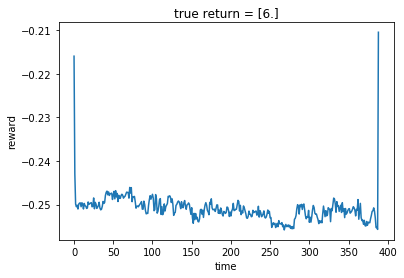

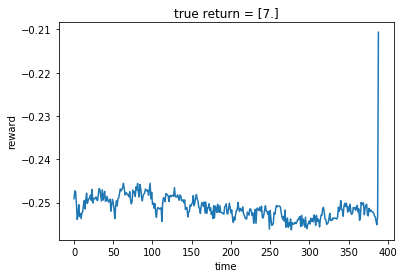

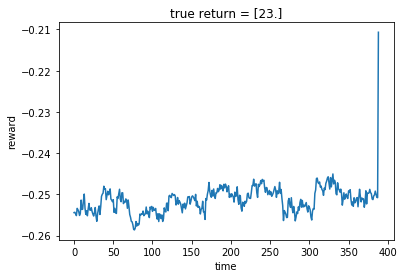

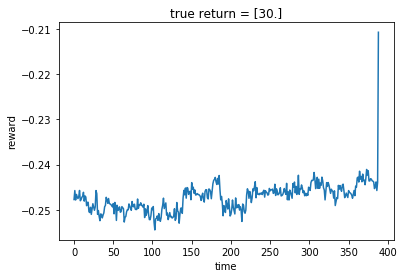

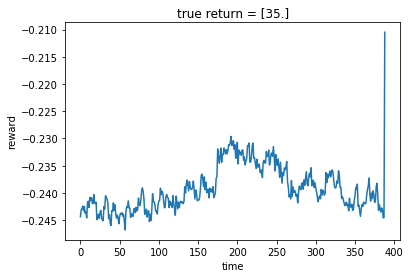

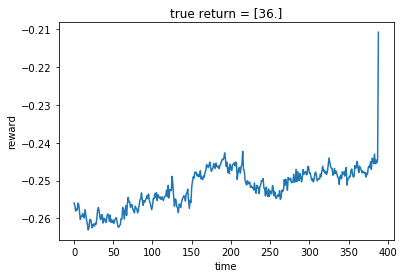

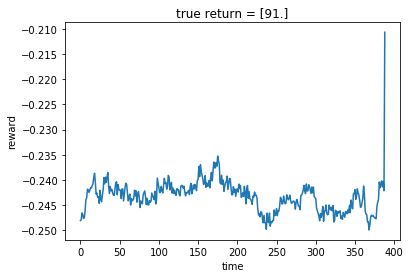

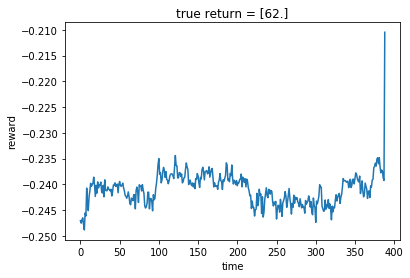

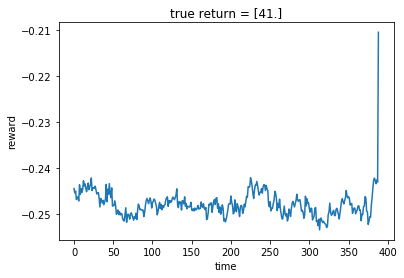

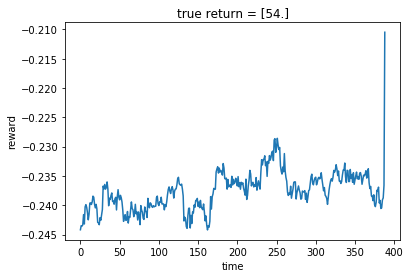

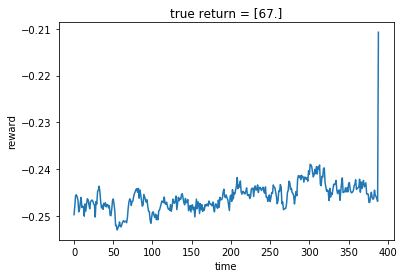

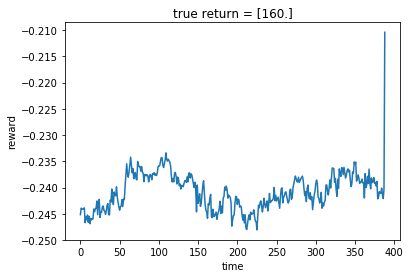

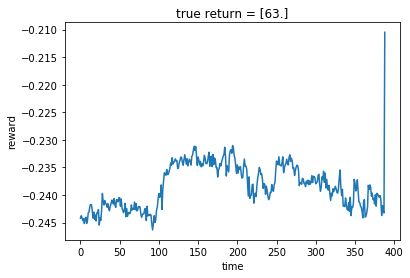

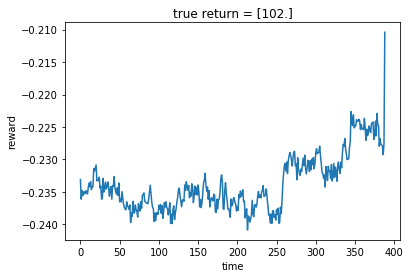

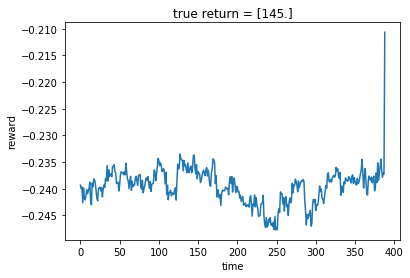

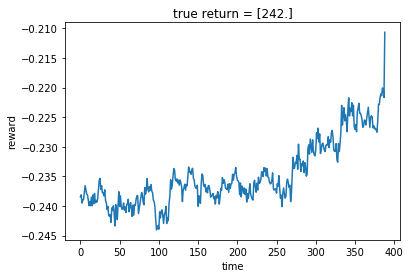

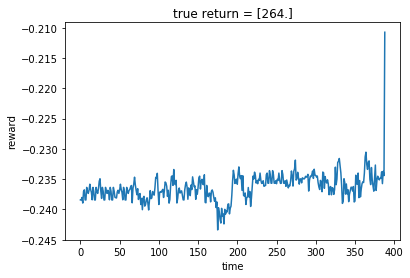

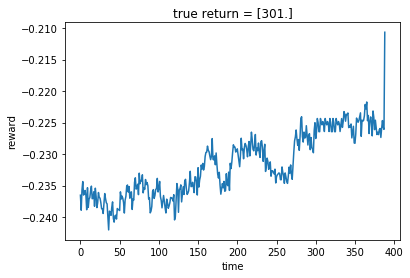

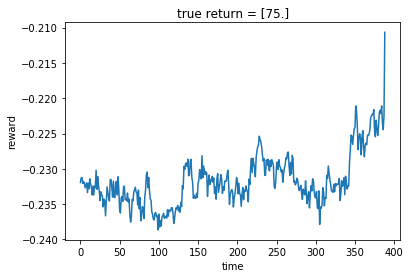

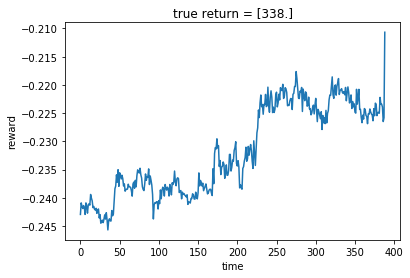

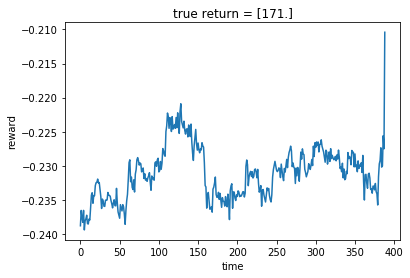

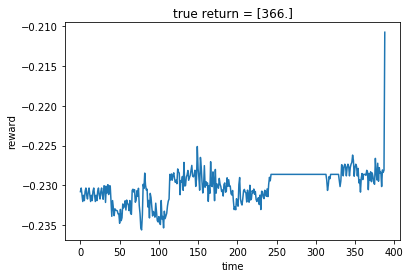

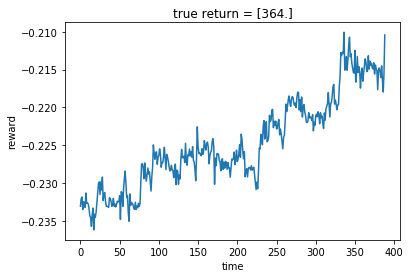

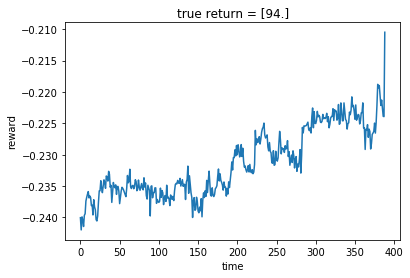

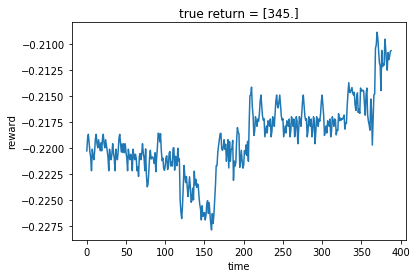

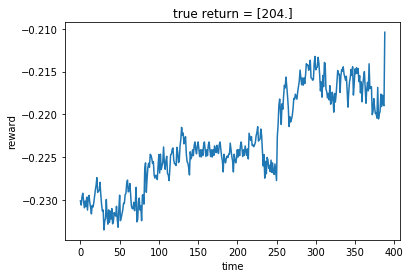

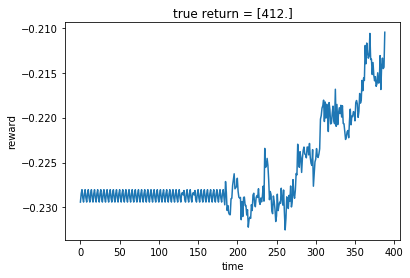

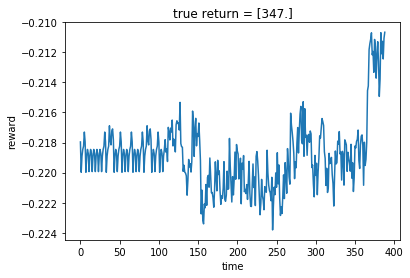

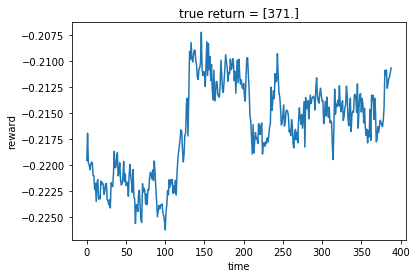

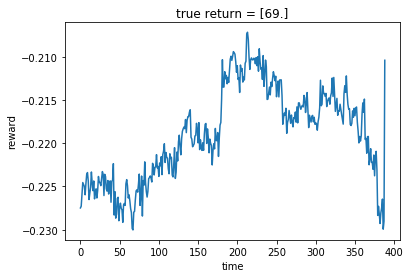

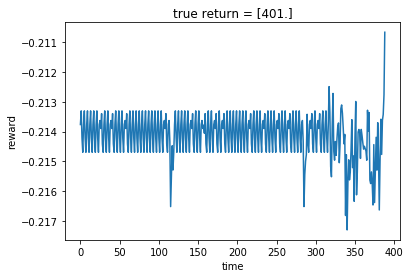

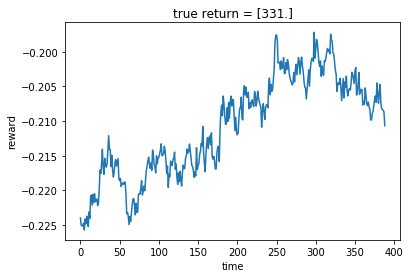

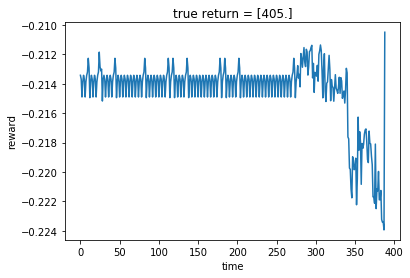

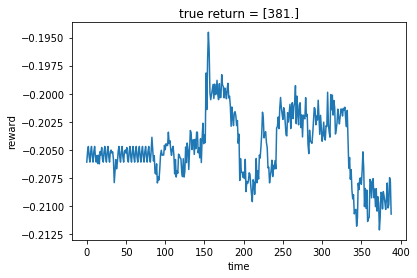

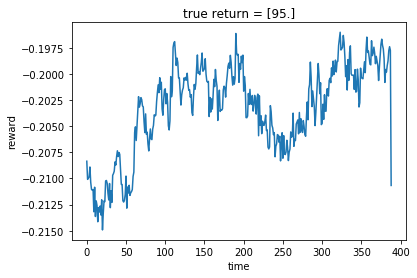

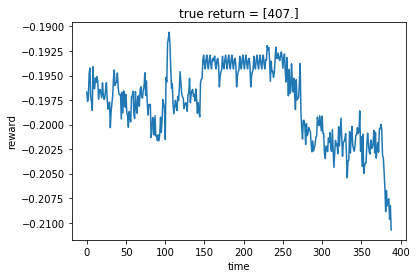

In [23]:
for d in demos_fh:
    print(len(d))

cnt = 0
with torch.no_grad():
    for d in demos_fh:
        rewards = []
        print(cnt)
        for s in d:
            r = reward_fh.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(learning_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()

Okay. So now we want to optimize a policy using the learned reward to see how well it can perform if we run RL to convergence on it.

In [ ]:
#class that makes a reward function out of a neural network
class NNetReward:
    def __init__(self,nnet):
        self.nnet = nnet
    def get_reward(self, state):
        #transform to tensor and input to nnet
        return self.nnet.cum_return(torch.from_numpy(np.array([state])).float()).item()
        

In [ ]:
#Run SARSA tilecoding on learned reward function
num_episodes = 1500

numOfTilings = 8
alpha = 0.5
n = 1

nn_reward = NNetReward(reward)


# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0.0
discount = 0.999 #using high discount factor

apprenticeVFunction = ValueFunction(alpha, numOfTilings)
for i in range(num_episodes):
    if i % 100 == 99:
        print(i, steps)
    r, s, steps = run_episode(env, apprenticeVFunction, n, False, EPSILON, max_time = 2000, reward_fn = nn_reward)
    
print("done training")
    


In [ ]:
#evaluate the learned policy
returns = evaluate_policy(env, 200, apprenticeVFunction)
print("best, worst, average", np.max(returns), np.min(returns), np.mean(returns))

In [ ]:
print("evaluate demonstrations")
demo_returns = learning_returns

print("best worst, average", np.max(demo_returns), np.min(demo_returns), np.mean(demo_returns))